In [30]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Task Description

Case description:
Welcome to East Carmen Airlines! As a strategic data scientist, you are confronted with many use cases to digitalize the airline business. Most important for airlines are accurate predictions of flight arrivals during a day of operations. When it comes to passenger handling, such predictions would admit a proactive steering, in order that the passengers reach the connection flights and therefore save a lot of money.

Your model should be applicable to each aircraft in East Carmen’s fleet. Let us take as an example the aircraft with registration name EC-LPD. At scheduled departure of the earliest morning flight from East Carmen’s hub Madrid the model should predict all flights of EC-LPD on the given day.

Many business stakeholders do not trust in the robustness of such a model. They claim that for a given aircraft, one could predict the first flight of the day with a decent error, but the errors of second and third flights will be huge. It is now your task to convince the business stakeholders that with a well-prepared data set and meaningful features you can deliver robust flight predictions.

Project Aim:
From different departments business analysts have collected a lot of information on possible features for flight predictions. Now it is your task to use these data to deliver a prototype forecasting model for all flights of a given aircraft at scheduled departure of the first flight of the day. 

For instance, for an aircraft with registration name EC-LPD, first flight of the day (FFOD) scheduled at 5:30 am from MAD to VIE and with the connection chain MAD-VIE-MAD-CDG-MAD-LHR-MAD your model should predict the successive landing times in VIE, MAD, CDG, MAD, LHR, MAD. The colleagues from daily operations are especially interested in how the confidence level of such a model evolves during a day of operations.

# General Information
| Amendments by me


3.1 File Names
- zip-folder: use_case_3.zip
- flight_information.csv : information on flights in a given time period, where each data point is a so-called 
leg, i.e. a flight from departure airport to destination airport with all relevant flight and crew information
- ground_information.csv : information on the ground processes after landing at our hub “East Carmen”,
where each data point describes the processes between two flights (inbound = landing, outbound = takeoff).


3.2 Column Description – Flight Information
- leg_no: unique identifier of a flight on a given day, at a certain time, with a given flight number
- fn_carrier: airline name
- fn_number: flight number; has to be unique on a given day
- dep_ap_sched: scheduled departure airport
- arr_ap_sched: scheduled arrival airport
- dep_sched_date: scheduled departure date
- dep_sched_time: scheduled departure time
- arr_sched_date: scheduled arrival date
- arr_sched_time: scheduled arrival time
- m_offblockdt: timestamp of departure
- m_onblockdt: timestamp of arrival
- ac_registration: aircraft registration number, i.e. the “license plate” of the aircraft
- change_reason_code: reason for delay (assigned after the flight)
- dep_delay: departure delay
- Ac Type Code: aircraft type (example: 320 = Airbus A320)
- trans_time: true minimal transition time for crew members after flight, i.e. transition time of the crew
member with the least time
- sched_trans_time: scheduled minimal transition time for crew members after flight, i.e. scheduled transition
time of the crew member with the least time
4
- Crew Group: assignment of what happens to the whole crew after a flight
o Start : First flight of day
o A : all crew members stay on the aircraft for the next flight
o B, B2: all crew members switch aircraft for the next flight
o C: at least one crew member switches aircraft for the next flight
- TLC_trans: names of crew members on flight with some additional information attached to each name (but business does not know exactly which additional information is visible there)
- crew_type_change: rank (cp = pilot, ca = cabin member) of crew members, who changed aircraft
- Sched Groundtime: scheduled ground time of the aircraft between flights | has mistakes; mostly (dep_sched_time of next line) - (arr_sched_time of current line); groundtime AFTER landing
- Act Groundtime: actual ground time of the aircraft between flights | has mistakes; mostly (m_offblocktime of next line) - (m_onblocktime of current line); groundtime AFTER landing


3.3 Column Description – Ground Information
- Each datapoint consists of an inbound (=arriving) flight and an outbound (=departing) flight from our hub “East Carmen)
- Catering, cleaning and pax (=passenger) boarding durations given for our hub “East Carmen” between the inbound and outbound flights
- day_of_origin: day of flight (also given in Flight Information)
- ac_type: aircraft type (also given in Flight Information)
- fn_number: flight number (also given in Flight Information)
- ac_registration: aircraft registration (also given in Flight Information)
- mingt: minimal scheduled ground time for the given aircraft
- dep_leg_inbound: departure airport name of inbound (=arriving) flight
- arr_leg_inbound: arrival airport name of inbound (=arriving) flight
- arr_leg_outbound: departure airport name of outbound (=departing) flight
- sched_inbound_dep: scheduled departure time of inbound (=arriving) flight
- sched_inbound_arr: scheduled arrival time of inbound (=arriving) flight
- sched_outbound_dep: scheduled departure time of outbound (=departing) flight
- sched_outbound_arr: scheduled arrival time of outbound (=departing) flight
- sched_turnaround: scheduled ground time for aircraft
- leg_inbound: leg number of inbound flight
- leg_outbound: leg number of outbound flight
- catering_duration: catering duration (i.e. filling up meal boxes) between flights in minutes
- cleaning_duration: cleaning duration between flights in minutes
- pax_boarding_duration: boarding duration between flights in minutes


3.4 Additional Info from Business Side:
- BI (=business intelligence) colleagues have collected a lot of flight information from many different de-partments: flight-, crew- and ground operations. Each department uses a different data warehouse. BI colleagues claim that some of the columns might be redundant and some information could be wrong, due to bad and not consistent data in the different data warehouses of the business departments. It is central for this prototype study to clean and transform the data and make consistency checks, before applying a machine learning algorithm.

# Initial Dataset Structure

In [31]:
# some general functions

def na_count(dataframe):
    '''Takes a Pandas dataframe as input and returns NA-Values per attribute.'''
    for attribute in dataframe.columns:
        nan_abs = str(dataframe[attribute].isna().sum()) 
        nan_percent = str(round(dataframe[attribute].isna().sum() / dataframe.shape[0] *100, 2))

        print(str(attribute) + " NAs: " + nan_abs + "(" + nan_percent + "%)" )



In [35]:
# Read files 

flt_info = pd.read_csv('../data/raw/flight_information.csv', index_col = 0)
ground_info = pd.read_csv('../data/raw/ground_information.csv', index_col = 0)

# Variable type conversions

data_type_dict_flt_info = {
    'm_offblockdt' : 'datetime64',
    'm_onblockdt' : 'datetime64',
    'arr_sched_time' : 'datetime64',
    'dep_sched_time' : 'datetime64',
    'dep_sched_date' : 'datetime64',
    'arr_sched_date' : 'datetime64',
    
    
#    'fn_carrier' : 'category',
#    'fn_number' : 'category',
#    'dep_ap_sched' : 'category',
#    'arr_ap_sched' : 'category',
#    'ac_registration' : 'category',
#    'ac_registration' : 'category',


}

data_type_dict_ground_info = {
    'day_of_origin' : 'datetime64',
    'sched_inbound_dep' : 'datetime64',
    'sched_inbound_arr' : 'datetime64',
    'sched_outbound_dep' : 'datetime64',
    'sched_outbound_arr' : 'datetime64',
}

flt_info = flt_info.astype(data_type_dict_flt_info)
ground_info = ground_info.astype(data_type_dict_ground_info)

# calculate block time 
flt_info["block_time"] = flt_info['m_onblockdt']-flt_info['m_offblockdt']
# Convert to minutes
flt_info["block_time"] = flt_info["block_time"].dt.total_seconds()/60


# Add routing column 
flt_info['leg'] = flt_info["dep_ap_sched"] + "-" + flt_info["arr_ap_sched"]
flt_info['route'] = np.where(flt_info["dep_ap_sched"]<flt_info["arr_ap_sched"], 
    flt_info["dep_ap_sched"] + "-" + flt_info["arr_ap_sched"],
    flt_info["arr_ap_sched"] + "-" + flt_info["dep_ap_sched"]
    )

# Joining Datasets

full_df = pd.merge(flt_info, ground_info, left_on = ['fn_number', 'dep_sched_date'], right_on = ['fn_number','day_of_origin'], how = 'left')
full_df.head()

# We save the full unedited dataset

full_df_unedited = full_df
full_df_unedited.to_csv('../data/interim/full_df_unedited.csv')
full_df_unedited.to_pickle('../data/interim/full_df_unedited.pkl')

full_df.head()


,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,block_time,leg,route,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
0,272005011,East Carmen Airlines,EC3098,North Gregory,East Carmen,2019-06-01,2022-05-01 00:40:00,2019-06-01,2022-05-01 04:30:00,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0,0,Start,"['Jason Brown_nan_nan_nan_cp', 'Jacob Stein_na...",[],235.0,268.0,209.0,North Gregory-East Carmen,East Carmen-North Gregory,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,272009188,East Carmen Airlines,EC3146,Port Bobby,East Carmen,2019-06-01,2022-05-01 02:05:00,2019-06-01,2022-05-01 04:00:00,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0,0,Start,"['Scott Baker_nan_nan_nan_cp', 'Ruth Hoffman_n...",[],130.0,189.0,102.0,Port Bobby-East Carmen,East Carmen-Port Bobby,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,271984537,East Carmen Airlines,EC2840,Port Ryan,East Carmen,2019-06-01,2022-05-01 02:20:00,2019-06-01,2022-05-01 03:50:00,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0,0,Start,"['Cory Cooper_nan_nan_nan_ca', 'Morgan Foster_...",[],185.0,196.0,93.0,Port Ryan-East Carmen,East Carmen-Port Ryan,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,272025831,East Carmen Airlines,EC3306,Coleland,East Carmen,2019-06-01,2022-05-01 02:25:00,2019-06-01,2022-05-01 04:00:00,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0,0,Start,"['Anne Davis_nan_nan_nan_ca', 'Miss Amanda Har...",[],145.0,175.0,81.0,Coleland-East Carmen,Coleland-East Carmen,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,272006092,East Carmen Airlines,EC3114,East Melissaberg,East Carmen,2019-06-01,2022-05-01 02:30:00,2019-06-01,2022-05-01 04:15:00,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0,0,Start,"['Renee Fisher_nan_nan_nan_ca', 'Rebecca Castr...",[],35.0,21.0,101.0,East Melissaberg-East Carmen,East Carmen-East Melissaberg,2019-06-01,DH4,ECLGNX,35.0,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35.0,272006092.0,272205857.0,26.0,NaN,26.0


# Dataset Analysis

In [33]:
# Count of rows and columns of our data set
full_df.shape

(12185, 42)

### Rotation Analysis

This section aims at analysing for rotational mismatches, creating an indicator for it in the first place.

In [34]:
# Sorting data frame correctly
full_df = full_df.sort_values(by = ['ac_registration_x', 'm_offblockdt']).reset_index(drop = True)

# Create binary column indicating rotational mistakes
full_df['rot_mismatch'] = np.where(
    full_df['ac_registration_x'].shift(1).eq(full_df['ac_registration_x']) == True, # Where the registration is the same as the row above
    ~full_df['arr_ap_sched'].shift(1).eq(full_df['dep_ap_sched']), # Check whether current arr ap is the same as prev. dep ap | Tilde negates the bool value
    False # Set false in case the registrations are not equal, as then a new ac rotation pattern follows
)

# Create df with only dep_sched_date and ac_registration of rotational mistakes
rot_mistakes = full_df[full_df['rot_mismatch'] == True][['dep_sched_date','ac_registration_x']]

# Exclude full day of aircraft if there is one rotational mismatch
# As a rotational mismatch often causes further mistakes in the following lines, we exclude everything for the moment. By this, we lose 666 observations.
#flt_info_3_removed_rot_mistakes = flt_info.merge(rot_mistakes, how = 'outer', on = ['dep_sched_date','ac_registration'], indicator = True) # merge with table of rotational mistakes
#print(flt_info_3_removed_rot_mistakes['_merge'].value_counts())
#flt_info_3_removed_rot_mistakes = flt_info_3_removed_rot_mistakes[flt_info_3_removed_rot_mistakes['_merge'] == 'left_only'] # Filter out observations occuring in both

# save changed dataframe
#flt_info_3_removed_rot_mistakes.to_csv(
#    path_or_buf = 'C:/Users/PC Paul/Documents/Dokumente/DATA SCIENCE/Courses/Model_Engineering/Delay-Prediction/data/interim/flt_info_3_removed_rot_mistakes.csv')

#flt_info = flt_info_3_removed_rot_mistakes

full_df.to_csv('C:/Users/PC Paul/Documents/Dokumente/DATA SCIENCE/Courses/Model_Engineering/Delay-Prediction/data/interim/full_df_rotation_analysis.csv')

rot_mistakes

,dep_sched_date,ac_registration_x
375,2019-06-13,ECLBCX
551,2019-06-21,ECLBDX
679,2019-06-14,ECLBEX
856,2019-06-19,ECLBFX
956,2019-06-10,ECLBIX
...,...,...
11442,2019-06-27,ECLXAX
11443,2019-06-27,ECLXAX
11444,2019-06-27,ECLXAX
11445,2019-06-27,ECLXAX


In [28]:
# Dataframe for analysis of rotational mistakes

rot_mistakes_analysis = full_df.merge(rot_mistakes, how = 'outer', on = ['dep_sched_date','ac_registration_x'], indicator = True) # merge with table of rotational mistakes
#print(rot_mistakes_analysis['_merge'].value_counts())
rot_mistakes_analysis = rot_mistakes_analysis[rot_mistakes_analysis['_merge'] == 'both'] # This creates the dataframe of all registrations and days having rotational mistakes. Let's see how we can fix them

rot_mistakes_analysis.head(10)

# We create a rolling window to analyse why lines get rotational mismatches
N = 1
mask = (full_df['rot_mismatch']
        .rolling(2*N+1, center=True, min_periods=1)
        .max().astype(bool)
       )
rotation_mismatch_lines = full_df.loc[mask]
rotation_mismatch_lines


,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,block_time,leg,route,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rot_mismatch
374,271958002,East Carmen Airlines,EC2582,Lake Lawrencechester,East Carmen,2019-06-12,2022-05-01 17:50:00,2019-06-12,2022-05-01 19:15:00,2019-06-12 18:00:00,2019-06-12 19:19:00,ECLBCX,other problem,10.0,320,47,70,A,"['David Cruz_286_47_70_ca', 'Veronica Nunez_28...",[],NaN,NaN,79.0,Lake Lawrencechester-East Carmen,East Carmen-Lake Lawrencechester,2019-06-12,321,ECLBCX,45.0,Lake Lawrencechester,East Carmen,East Latashaview,2019-06-12 17:50:00,2019-06-12 19:15:00,2019-06-12 18:15:00,2019-06-12 21:40:00,-60.0,271958002.0,272213781.0,23.0,NaN,19.0,False
375,272027082,East Carmen Airlines,EC3316,East Latashaview,East Carmen,2019-06-13,2022-05-01 03:15:00,2019-06-13,2022-05-01 07:05:00,2019-06-13 03:34:00,2019-06-13 07:16:00,ECLBCX,other problem,19.0,320,0,0,Start,"['Reginald Grant_nan_nan_nan_cp', 'Jason Chane...",[],75.0,132.0,222.0,East Latashaview-East Carmen,East Carmen-East Latashaview,2019-06-13,321,ECLBCX,45.0,East Latashaview,East Carmen,South Nathaniel,2019-06-13 03:15:00,2019-06-13 07:05:00,2019-06-13 08:20:00,2019-06-13 10:35:00,75.0,272027082.0,272022242.0,15.0,NaN,33.0,True
376,272022242,East Carmen Airlines,EC3257,East Carmen,South Nathaniel,2019-06-13,2022-05-01 08:20:00,2019-06-13,2022-05-01 10:35:00,2019-06-13 09:28:00,2019-06-13 11:39:00,ECLBCX,technical problem,68.0,320,54,60,B2,"['Debra Brown_55_54_60_ca', 'Bruce Baker_55_54...","['ca', 'ca', 'ca', 'cp', 'ca']",75.0,121.0,131.0,East Carmen-South Nathaniel,East Carmen-South Nathaniel,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
550,272024194,East Carmen Airlines,EC3288,New Jessica,East Carmen,2019-06-20,2022-05-01 13:50:00,2019-06-20,2022-05-01 17:15:00,2019-06-20 14:13:00,2019-06-20 17:24:00,ECLBDX,other problem,23.0,320,0,0,Start,"['Angel Vazquez_nan_nan_nan_ca', 'Patrick Brow...",[],NaN,NaN,191.0,New Jessica-East Carmen,East Carmen-New Jessica,2019-06-20,322,ECLBDX,45.0,New Jessica,East Carmen,East Latashaview,2019-06-20 13:50:00,2019-06-20 17:15:00,2019-06-20 18:15:00,2019-06-20 21:40:00,60.0,272024194.0,272213789.0,25.0,NaN,20.0,False
551,272027090,East Carmen Airlines,EC3316,East Latashaview,East Carmen,2019-06-21,2022-05-01 03:15:00,2019-06-21,2022-05-01 07:05:00,2019-06-21 03:33:00,2019-06-21 07:11:00,ECLBDX,other problem,18.0,320,0,0,Start,"['Emily Williams_nan_nan_nan_ca', 'Jerry Tyler...",[],75.0,90.0,218.0,East Latashaview-East Carmen,East Carmen-East Latashaview,2019-06-21,322,ECLBDX,45.0,East Latashaview,East Carmen,New Jessica,2019-06-21 03:15:00,2019-06-21 07:05:00,2019-06-21 08:20:00,2019-06-21 11:25:00,75.0,272027090.0,272023985.0,29.0,NaN,22.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11443,272360102,East Carmen Airlines,EC3117,Lake Joelbury,East Carmen,2019-06-27,2022-05-01 11:30:00,2019-06-27,2022-05-01 12:30:00,2019-06-27 12:27:00,2019-06-27 13:29:00,ECLXAX,other problem,57.0,320,23,105,A,"['Laura Meyer_100_23_105_ca', 'Shane Vang_100_...",[],50.0,32.0,62.0,Lake Joelbury-East Carmen,East Carmen-Lake Joelbury,2019-06-27,320,ECLXAX,40.0,Lake Joelbury,East Carmen,Youngland,2019-06-27 11:30:00,2019-06-27 12:30:00,2019-06-27 13:20:00,2019-06-27 14:55:00,50.0,272360102.0,272020340.0,28.0,NaN,51.0,True
11444,272360102,East Carmen Airlines,EC3117,Lake Joelbury,East Carmen,2019-06-27,2022-05-01 1

In [14]:
full_df

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,block_time,leg,route,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rot_mismatch
9,272024970,East Carmen Airlines,EC3292,New Jessica,East Carmen,2019-06-01,2022-05-01 03:25:00,2019-06-01,2022-05-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,320,0,0,Start,"['Sean Weeks_nan_nan_nan_ca', 'Tony Lloyd_nan_...",[],95.0,94.0,191.0,New Jessica-East Carmen,East Carmen-New Jessica,2019-06-01,321,ECLBAX,45.0,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,False
120,272022230,East Carmen Airlines,EC3257,East Carmen,South Nathaniel,2019-06-01,2022-05-01 08:20:00,2019-06-01,2022-05-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,320,60,60,B,"['Toni Rodriguez_48_60_60_ca', 'Rachel Smith_4...",[],75.0,120.0,126.0,East Carmen-South Nathaniel,East Carmen-South Nathaniel,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
198,272212848,East Carmen Airlines,EC3258,South Nathaniel,East Carmen,2019-06-01,2022-05-01 11:50:00,2019-06-01,2022-05-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,320,68,75,A,"['Toni Rodriguez_127_68_75_ca', 'Rachel Smith_...",[],80.0,86.0,131.0,South Nathaniel-East Carmen,East Carmen-South Nathaniel,2019-06-01,321,ECLBAX,45.0,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,False
289,271997824,East Carmen Airlines,EC3021,East Carmen,Joneshaven,2019-06-01,2022-05-01 15:35:00,2019-06-01,2022-05-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,320,64,70,B2,"['Tyler Morris_224_64_70_ca', 'Sergio Cummings...","['ca', 'cp', 'ca', 'ca', 'ca']",50.0,32.0,74.0,East Carmen-Joneshaven,East Carmen-Joneshaven,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
323,271998033,East Carmen Airlines,EC3022,Joneshaven,East Carmen,2019-06-01,2022-05-01 17:50:00,2019-06-01,2022-05-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,320,42,50,A,"['Sergio Cummings_279_42_50_cp', 'Jackie Black...",[],NaN,NaN,70.0,Joneshaven-East Carmen,East Carmen-Joneshaven,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11940,272211046,East Carmen Airlines,EC3234,Lisamouth,East Carmen,2019-06-30,2022-05-01 10:30:00,2019-06-30,2022-05-01 12:10:00,2019-06-30 10:34:00,2019-06-30 12:05:00,ECLXEX,other problem,4.0,320,37,45,A,"['Tyler Welch_109_37_45_ca', 'Kenneth Alvarado...",[],50.0,85.0,91.0,Lisamouth-East Carmen,East Carmen-Lisamouth,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
12000,271969272,East Carmen Airlines,EC2687,East Carmen,West Jason,2019-06-30,2022-05-01 13:00:00,2019-06-30,2022-05-01 14:15:00,2019-06-30 13:30:00,2019-06-30 14:36:00,ECLXEX,rotational problem,30.0,320,0,0,Start,"['Carol Owens_nan_nan_nan_ca', 'Andrew Case_na...",[],45.0,54.0,66.0,East Carmen-West Jason,East Carmen-West Jason,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
12043,271969452,East Carmen Airlines,EC2688,West Jason,East Carmen,2019-06-30,2022-05-01 15:00:00,2019-06-30,2022-05-01 16:20:00,2019

In [ ]:
# Rechecking the outliers

sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(data = flt_info.drop(['leg_no'], axis = 1))
flt_info.describe()

### Duplicate Removal

In [45]:
# We exclude complete data dupes and save them in case they are needed later on

dupes = full_df[full_df.duplicated()]
dupes.to_csv('../data/interim/duplicates.csv')
full_df = full_df.drop_duplicates()
full_df.shape

(12069, 42)

Unique values per categorical feature

<AxesSubplot:title={'center':'Unique values per feature'}>

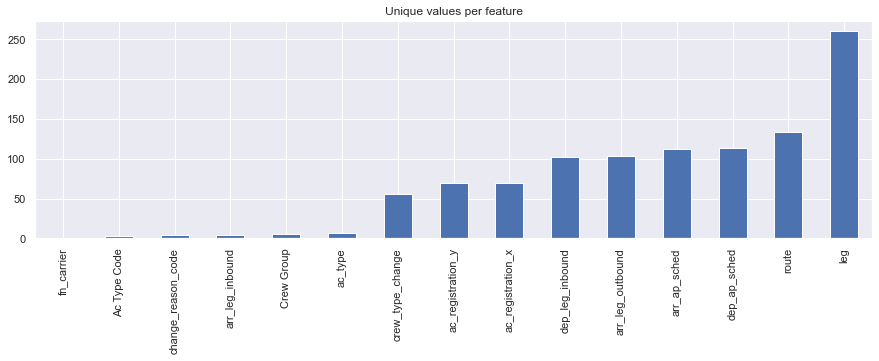

In [46]:
unique_values = full_df.select_dtypes(include = 'object').nunique().sort_values().drop(['TLC_trans', 'fn_number'])

#plot
unique_values.plot.bar(figsize = (15,4), title = "Unique values per feature")

### NaN Analysis

In [47]:
# Count the number of NAs per variable
na_count(full_df)

full_df.describe()

leg_no NAs: 0(0.0%)
fn_carrier NAs: 0(0.0%)
fn_number NAs: 0(0.0%)
dep_ap_sched NAs: 0(0.0%)
arr_ap_sched NAs: 0(0.0%)
dep_sched_date NAs: 0(0.0%)
dep_sched_time NAs: 0(0.0%)
arr_sched_date NAs: 0(0.0%)
arr_sched_time NAs: 0(0.0%)
m_offblockdt NAs: 0(0.0%)
m_onblockdt NAs: 85(0.7%)
ac_registration_x NAs: 0(0.0%)
change_reason_code NAs: 0(0.0%)
dep_delay NAs: 0(0.0%)
Ac Type Code NAs: 0(0.0%)
trans_time NAs: 0(0.0%)
sched_trans_time NAs: 0(0.0%)
Crew Group NAs: 0(0.0%)
TLC_trans NAs: 0(0.0%)
crew_type_change NAs: 0(0.0%)
Sched Groundtime NAs: 2013(16.68%)
Act Groundtime NAs: 2077(17.21%)
block_time NAs: 85(0.7%)
leg NAs: 0(0.0%)
route NAs: 0(0.0%)
day_of_origin NAs: 7844(64.99%)
ac_type NAs: 7844(64.99%)
ac_registration_y NAs: 7844(64.99%)
mingt NAs: 7844(64.99%)
dep_leg_inbound NAs: 7844(64.99%)
arr_leg_inbound NAs: 7844(64.99%)
arr_leg_outbound NAs: 7849(65.03%)
sched_inbound_dep NAs: 7844(64.99%)
sched_inbound_arr NAs: 7844(64.99%)
sched_outbound_dep NAs: 7844(64.99%)
sched_outbound_

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,block_time,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
count,1.206900e+04,12069.000000,12069.000000,12069.000000,10056.000000,9992.000000,11984.000000,4225.000000,4225.000000,4.225000e+03,4.225000e+03,4225.000000,3.000000,3813.000000
mean,2.720516e+08,25.787555,27.785318,35.034800,62.422932,66.099480,94.769192,39.117160,56.072189,2.720599e+08,2.720432e+08,21.955976,21.505556,18.433517
std,9.574944e+04,25.623063,31.879903,31.456121,57.134578,71.796378,41.627719,3.251493,16.982632,9.866309e+04,9.313579e+04,4.322899,10.667400,11.873463
min,2.719556e+08,-14.000000,-134.000000,0.000000,-245.000000,-383.000000,28.000000,30.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000
25%,2.719825e+08,9.000000,0.000000,0.000000,45.000000,33.000000,68.000000,40.000000,45.000000,2.719897e+08,2.719841e+08,18.000000,15.400000,13.000000
50%,2.720115e+08,17.000000,28.000000,45.000000,50.000000,60.000000,86.000000,40.000000,55.000000,2.720156e+08,2.720094e+08,22.000000,16.800000,17.000000
75%,2.721016e+08,34.000000,49.000000,50.000000,65.000000,87.000000,110.000000,40.000000,65.000000,2.721833e+08,2.720343e+08,26.000000,25.258333,22.000000
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,333.000000,45.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000


<AxesSubplot:>

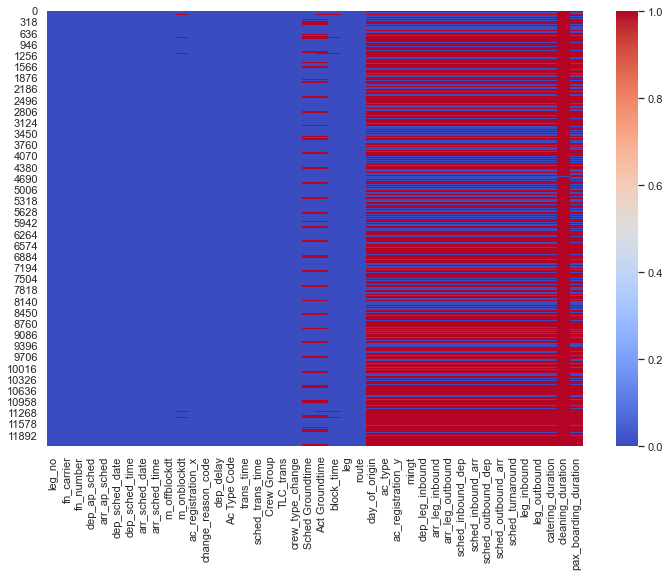

In [59]:
sns.heatmap(full_df.isnull(), cmap='coolwarm')

Assumption: If m_onblockdt is NA, the flight did not depart to its flight and the flight was cancelled. The row can therefore be removed, we lose 83 observations by doing so (see above)

In [49]:
# THIS ASSUMPTION IS PROBABLY WRONG AND CAUSES ROTATIONAL MISTAKES LATER ON
# MAYBE REMOVE AFTER YOU CHECK FOR ROTATIONAL MISTAKES
# all of them are dupe leg_nos anyways. However, if we remove these NAs, we should do so before fixing the leg_nos

# Removal of NA rows in m_onblockdt. 
#flt_info = flt_info.dropna(subset = ['m_onblockdt'])

# saving intermediate df
#flt_info_1_removed_onblockdt_na = flt_info
#flt_info_1_removed_onblockdt_na.to_csv(
#    path_or_buf = '../data/interim/flt_info_1_removed_onblockdt_na.csv')

In [60]:
full_df.shape

(12069, 42)

TH1: If Sched Groundtime is NA, Act Groundtime is also NA --> True. Act Groundtime also has more NAs than Sched Groundtime. See H3


(7887, 42)

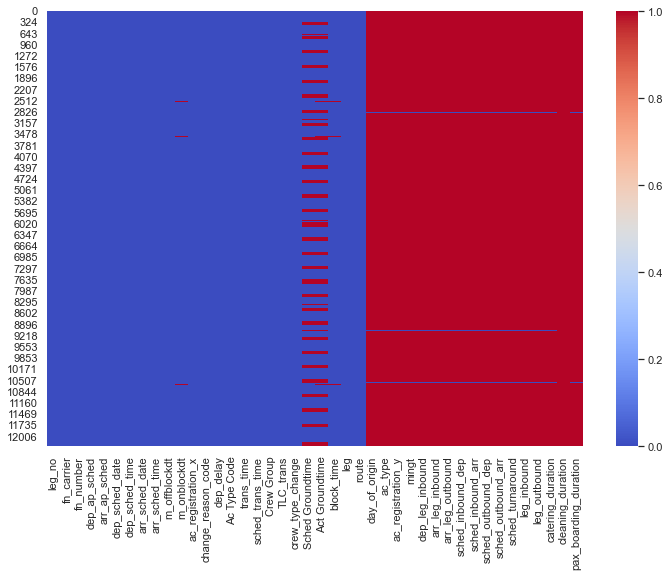

In [65]:
#Hypothesis 1:
full_df_NA = full_df[full_df.drop(['cleaning_duration', 'pax_boarding_duration'], axis = 1).isna().any(axis = 1)]
sns.heatmap(full_df_NA.isnull(), cmap='coolwarm')

In [66]:
full_df_NA.describe()
# Whenever there is a line with a NA value, Act Groundtime has NA. 

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,block_time,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
count,7.887000e+03,7887.000000,7887.000000,7887.000000,5874.000000,5810.000000,7802.000000,43.000000,43.000000,4.300000e+01,4.300000e+01,43.000000,0.0,37.000000
mean,2.720474e+08,26.060226,27.735514,34.558768,68.003064,63.834251,95.116893,39.767442,56.744186,2.720590e+08,2.720523e+08,23.372093,NaN,18.189189
std,9.407281e+04,23.748226,33.641398,33.221764,69.687373,84.214301,42.241408,2.169455,30.723105,8.830805e+04,1.265128e+05,4.123240,NaN,9.500988
min,2.719556e+08,-14.000000,-134.000000,0.000000,-245.000000,-270.000000,28.000000,30.000000,-65.000000,2.719580e+08,2.719571e+08,15.000000,NaN,7.000000
25%,2.719796e+08,12.000000,0.000000,0.000000,45.000000,22.250000,68.000000,40.000000,50.000000,2.720284e+08,2.719688e+08,21.000000,NaN,14.000000
50%,2.720086e+08,19.000000,25.000000,40.000000,45.000000,48.000000,86.000000,40.000000,60.000000,2.720284e+08,2.719878e+08,24.000000,NaN,16.000000
75%,2.721009e+08,34.000000,51.000000,55.000000,65.000000,78.000000,110.000000,40.000000,70.000000,2.720303e+08,2.720664e+08,26.500000,NaN,20.000000
max,2.723603e+08,149.000000,470.000000,495.000000,945.000000,947.000000,333.000000,45.000000,100.000000,2.723601e+08,2.723527e+08,29.000000,NaN,51.000000


H2: Last flight of the day has no value for Sched Groundtime and Act Groundtime

In [68]:
#analysis for single registration and dep day
full_df[(full_df['ac_registration_x'] == 'ECLWHX') & (full_df['dep_sched_date'] == "2019-06-14")]

# We see that the last flight of a given day has no Sched Groundtime and no Act Groundtime, at least in this example. However, it repeats for different combinations,
# so we assume it's universally true. 

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,block_time,leg,route,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
5315,271994247,East Carmen Airlines,EC2984,East Holly,East Carmen,2019-06-14,2022-05-01 05:25:00,2019-06-14,2022-05-01 06:30:00,2019-06-14 05:25:00,2019-06-14 06:33:00,ECLWHX,no reason,0.0,E95,0,0,Start,"['Robert Holland_nan_nan_nan_ca', 'Brian Steve...",[],80.0,97.0,68.0,East Holly-East Carmen,East Carmen-East Holly,2019-06-14,E95,ECLWHX,40.0,East Holly,East Carmen,Lake David,2019-06-14 05:25:00,2019-06-14 06:30:00,2019-06-14 07:50:00,2019-06-14 09:40:00,80.0,271994247.0,272002947.0,22.0,NaN,23.0
5359,272002947,East Carmen Airlines,EC3075,East Carmen,Lake David,2019-06-14,2022-05-01 07:50:00,2019-06-14,2022-05-01 09:40:00,2019-06-14 08:10:00,2019-06-14 10:12:00,ECLWHX,other problem,20.0,E95,30,40,B,"['Janet Walls_31_30_40_cp', 'Melissa Walker_31...",[],55.0,35.0,122.0,East Carmen-Lake David,East Carmen-Lake David,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
5432,272003149,East Carmen Airlines,EC3076,Lake David,East Carmen,2019-06-14,2022-05-01 10:35:00,2019-06-14,2022-05-01 12:30:00,2019-06-14 10:47:00,2019-06-14 12:41:00,ECLWHX,other problem,12.0,E95,26,55,A,"['Janet Walls_105_26_55_cp', 'Melissa Walker_1...",[],50.0,66.0,114.0,Lake David-East Carmen,East Carmen-Lake David,2019-06-14,E95,ECLWHX,40.0,Lake David,East Carmen,West Danielport,2019-06-14 10:35:00,2019-06-14 12:30:00,2019-06-14 13:20:00,2019-06-14 14:50:00,50.0,272003149.0,271991661.0,25.0,NaN,8.0
5516,271991661,East Carmen Airlines,EC2969,East Carmen,West Danielport,2019-06-14,2022-05-01 13:20:00,2019-06-14,2022-05-01 14:50:00,2019-06-14 13:47:00,2019-06-14 15:05:00,ECLWHX,rotational problem,27.0,E95,0,0,Start,"['Daniel Olson_nan_nan_nan_cp', 'Courtney Camp...",[],50.0,44.0,78.0,East Carmen-West Danielport,East Carmen-West Danielport,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
5567,271991812,East Carmen Airlines,EC2970,West Danielport,East Carmen,2019-06-14,2022-05-01 15:40:00,2019-06-14,2022-05-01 17:10:00,2019-06-14 15:49:00,2019-06-14 17:08:00,ECLWHX,other problem,9.0,E95,40,50,A,"['Logan Beck_257_40_50_ca', 'Daniel Anderson_2...",[],65.0,80.0,79.0,West Danielport-East Carmen,East Carmen-West Danielport,2019-06-14,E95,ECLWHX,40.0,West Danielport,East Carmen,Davidtown,2019-06-14 15:40:00,2019-06-14 17:10:00,2019-06-14 18:15:00,2019-06-14 20:10:00,65.0,271991812.0,271983669.0,20.0,NaN,23.0
5630,271983669,East Carmen Airlines,EC2833,East Carmen,Davidtown,2019-06-14,2022-05-01 18:15:00,2019-06-14,2022-05-01 20:10:00,2019-06-14 18:28:00,2019-06-14 20:10:00,ECLWHX,other problem,13.0,E95,0,0,Start,"['Henry Rose_nan_nan_nan_cp', 'Melanie Fuentes...",[],NaN,NaN,102.0,East Carmen-Davidtown,Davidtown-East Carmen,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


Hypothesis 3: m_onblockdt NAs have values for Sched Groundtime but not for Act Groundtime (to be verified). Those could be cancelled/diverted etc. flts

<AxesSubplot:>

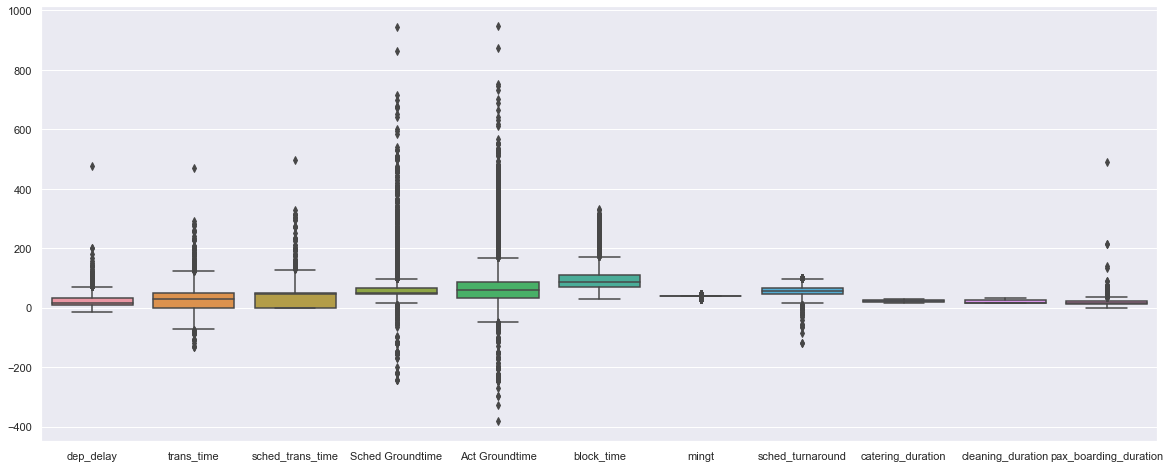

In [72]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.boxplot(data = full_df.drop(['leg_no', 'leg_inbound', 'leg_outbound'], axis = 1))

# Todo: Check negative ground time 



## Negative Ground Time Check

In [58]:
# 22APR: This cell is partially irrelevant as we remove dupes already at the beginning

# Excel analysis shows that many negative scheduled groundtimes are duplicate leg_no.
# Duplicate removal 
#flt_info_2_removed_dupes_leg_no = flt_info.drop_duplicates(subset = ['leg_no'], keep = False) #for the moment, we remove the duplicates completely as they are not many and we cannot say which one is correct.

#flt_info = flt_info_2_removed_dupes_leg_no

# 22APR: Note: if you reactivate these lines, save the removed rows, not the df
# save changed dataframe
#flt_info_2_removed_dupes_leg_no.to_csv(
#    path_or_buf = '../data/interim/flt_info_2_removed_dupes_leg_no.csv')

# And we see, the negative values reduce. 
#sns.set(rc={'figure.figsize':(12, 8)})
#sns.boxplot(data = flt_info.drop(['leg_no'], axis = 1))

#flt_info.describe()

# looking at the remaining values, we see some rotational mismatches


0        False
1        False
2        False
3        False
4        False
         ...  
12012    False
12013    False
12014    False
12015    False
12016    False
Length: 12017, dtype: bool

TH5: Groundtime reliability differs per A/C Registration

In [20]:
flt_info['Neg_Sched_Groundtime'] = np.where(flt_info['Sched Groundtime']<0,'Yes','No')
flt_info['Neg_Act_Groundtime'] = np.where(flt_info['Act Groundtime']<0,'Yes','No')
print(flt_info['Neg_Sched_Groundtime'].value_counts(), "\n")
print(flt_info['Neg_Act_Groundtime'].value_counts())

# We see that act groundtime has many more negative values than sched groundtime
flt_info.columns

No     11410
Yes       16
Name: Neg_Sched_Groundtime, dtype: int64 

No     10554
Yes      872
Name: Neg_Act_Groundtime, dtype: int64


Index(['leg_no', 'fn_carrier', 'fn_number', 'dep_ap_sched', 'arr_ap_sched',
       'dep_sched_date', 'dep_sched_time', 'arr_sched_date', 'arr_sched_time',
       'm_offblockdt', 'm_onblockdt', 'ac_registration', 'change_reason_code',
       'dep_delay', 'Ac Type Code', 'trans_time', 'sched_trans_time',
       'Crew Group', 'TLC_trans', 'crew_type_change', 'Sched Groundtime',
       'Act Groundtime', 'block_time', 'leg', 'route', 'rot_mismatch',
       '_merge', 'Neg_Sched_Groundtime', 'Neg_Act_Groundtime'],
      dtype='object')

In [21]:
pd.set_option("display.max_rows", 70)
pd.pivot_table(data = flt_info, values = ['Ac Type Code'], index = ['ac_registration'], columns = ['Neg_Act_Groundtime'], aggfunc = len)

#We see that this hypothesis is true

Ac Type Code      
Neg_Act_Groundtime           No   Yes
ac_registration                      
ECLBAX                    152.0   NaN
ECLBBX                    130.0  28.0
ECLBCX                    120.0  26.0
ECLBDX                    138.0   1.0
ECLBEX                    157.0   2.0
ECLBFX                    134.0   NaN
ECLBIX                    164.0   1.0
ECLBJX                    145.0   2.0
ECLBKX                    135.0  29.0
ECLBLX                    142.0  40.0
ECLBMX                    166.0   1.0
ECLBNX                    116.0  35.0
ECLBOX                    106.0  23.0
ECLBPX                    151.0  26.0
ECLBQX                    161.0   NaN
ECLBRX                    154.0   2.0
ECLBSX                    165.0   1.0
ECLBTX                    160.0   1.0
ECLBUX                    155.0   NaN
ECLBVX                    134.0  37.0
ECLBWX                    172.0   1.0
ECLBXX                    167.0   1.0
ECLBYX                    186.0   1.0
ECLBZX                    167.0   3.0
ECLDAX                    138.0  29.0
ECLDBX                    147.0   3.0
ECLDCX                    181.0   2.0
ECLDDX                    164.0   NaN
ECLDEX                    158.0   4.0
ECLDFX                    168.0   3.0
ECLDGX                    121.0  32.0
ECLGAX                    171.0  10.0
ECLGBX                    125.0  26.0
ECLGCX                    133.0   7.0
ECLGEX                      8.0   NaN
ECLGFX                    147.0  10.0
ECLGGX                    146.0   9.0
ECLGHX                    151.0   9.0
ECLGIX                    174.0  10.0
ECLGJX                    182.0   8.0
ECLGKX                    146.0   8.0
ECLGLX                    182.0  14.0
ECLGMX                    120.0   7.0
ECLGNX                     33.0   2.0
ECLGOX                    134.0   6.0
ECLGPX                    137.0  10.0
ECLGQX                     66.0  18.0
ECLGRX                    115.0  33.0
ECLWAX                    197.0   2.0
ECLWBX                    156.0  35.0
ECLWCX                    189.0   1.0
ECLWDX                    181.0   NaN
ECLWEX                    179.0   3.0
ECLWFX                    158.0  34.0
ECLWGX                    180.0   2.0
ECLWHX                    174.0   3.0
ECLWIX                    165.0  26.0
ECLWJX                    151.0  30.0
ECLWKX                    131.0  35.0
ECLWLX                    177.0  30.0
ECLWMX                    155.0  37.0
ECLWNX                    134.0  31.0
ECLWOX                    171.0  33.0
ECLWPX                    199.0   2.0
ECLWQX                    186.0   1.0
ECLXAX                    173.0   3.0
ECLXBX                    151.0  38.0
ECLXCX                    172.0   3.0
ECLXDX                    170.0   1.0
ECLXEX                    181.0   1.0

Hypothesis 4: Time of day has influence on dep delay

In [27]:
#create new df
flt_info_h4 = flt_info
flt_info_h4['dep_sched_time_of_day'] = flt_info_h4['dep_sched_time'].dt.date#.time
https://stackoverflow.com/questions/12155908/convert-datetime-since-a-given-date-to-minutes


flt_info_h4.tail()

#workaroud to create time of day with unique date as datetime
#dep_sched_time_of_day_datetime = [datetime.datetime.combine(datetime.date.today(), t) for t in flt_info_h4['dep_sched_time_of_day']]
#plt.plot(dep_sched_time_of_day_datetime, flt_info_h4['dep_delay'])

#flt_info_h4['dep_sched_time_of_day'] = flt_info_h4['dep_sched_time_of_day'].dt.minute
#flt_info_h4.set_index('dep_sched_time_of_day', inplace = True)



#groupby
#flt_info_h4.groupby('dep_sched_time_of_day').mean()

#plt.plot(flt_info_h4['dep_delay'])

#flt_info['dep_sched_time'].dt.time
#flt_info_h4['dep_sched_time_of_day']

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,block_time,leg,route,rot_mismatch,_merge,Neg_Sched_Groundtime,Neg_Act_Groundtime,dep_sched_time_of_day
12361,272211046,East Carmen Airlines,EC3234,Lisamouth,East Carmen,2019-06-30,2022-05-01 10:30:00,2019-06-30,2022-05-01 12:10:00,2019-06-30 10:34:00,2019-06-30 12:05:00,ECLXEX,other problem,4.0,320,37,45,A,"['Tyler Welch_109_37_45_ca', 'Kenneth Alvarado...",[],50.0,85.0,91.0,Lisamouth-East Carmen,East Carmen-Lisamouth,False,left_only,No,No,2022-05-01
12362,271969272,East Carmen Airlines,EC2687,East Carmen,West Jason,2019-06-30,2022-05-01 13:00:00,2019-06-30,2022-05-01 14:15:00,2019-06-30 13:30:00,2019-06-30 14:36:00,ECLXEX,rotational problem,30.0,320,0,0,Start,"['Carol Owens_nan_nan_nan_ca', 'Andrew Case_na...",[],45.0,54.0,66.0,East Carmen-West Jason,East Carmen-West Jason,False,left_only,No,No,2022-05-01
12363,271969452,East Carmen Airlines,EC2688,West Jason,East Carmen,2019-06-30,2022-05-01 15:00:00,2019-06-30,2022-05-01 16:20:00,2019-06-30 15:30:00,2019-06-30 16:40:00,ECLXEX,rotational problem,30.0,320,41,45,A,"['Carol Owens_210_41_45_ca', 'Andrew Case_210_...",[],45.0,57.0,70.0,West Jason-East Carmen,East Carmen-West Jason,False,left_only,No,No,2022-05-01
12364,272187492,East Carmen Airlines,EC2693,East Carmen,West Jason,2019-06-30,2022-05-01 17:05:00,2019-06-30,2022-05-01 18:20:00,2019-06-30 17:37:00,2019-06-30 19:01:00,ECLXEX,rotational problem,32.0,320,50,45,A,"['David Taylor_252_50_45_cp', 'Carol Owens_252...",[],45.0,4.0,84.0,East Carmen-West Jason,East Carmen-West Jason,False,left_only,No,No,2022-05-01
12365,272187671,East Carmen Airlines,EC2694,West Jason,East Carmen,2019-06-30,2022-05-01 19:05:00,2019-06-30,2022-05-01 20:20:00,2019-06-30 19:05:00,2019-06-30 20:15:00,ECLXEX,no reason,0.0,320,32,45,A,"['David Taylor_315_32_45_cp', 'Diana Smith_315...",[],NaN,NaN,70.0,West Jason-East Carmen,East Carmen-West Jason,False,left_only,No,No,2022-05-01


Questions

! Leg and AC-Type are not sufficient for predictions as observations become too little!

(array([85., 62., 30., 33.,  8.,  7., 11.,  6.,  9., 16., 13., 10., 12.,
         8.,  2.,  0.,  6.,  3.,  3.,  4.,  4.,  4.,  7.,  4.,  6.,  5.,
         1.,  1.,  2.,  2.,  2.,  4.,  1.,  5.,  2.,  1.,  3.,  2.,  0.,
         0.,  3.,  2.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  2.,  0.,
         4.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         4.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,
         0.,  2.]),
 array([  1.   ,   3.275,   5.55 ,   7.825,  10.1  ,  12.375,  14.65 ,
         16.925,  19.2  ,  21.475,  23.75 ,  26.025,  28.3  ,  30.575,
         32.85 ,  35.125,  37.4  ,  39.675,  41.95 ,  44.225,  46.5  ,
         48.775,  51.05 ,  53.325,  55.6  ,  57.875,  60.15 ,  62.425,
         64.7  ,  66.975,  69.25 ,  71.525,  73.8  ,  76.075,  78.35 ,
         80.625,  82.9  ,  85.175,  87.45 ,  89.725,  92.   ,  94.275,
         96.55 ,  98.825, 101.1  , 103.375, 105.65 , 107.925, 110.2  ,
        112.475, 114.75 , 117.025, 119.3  , 1

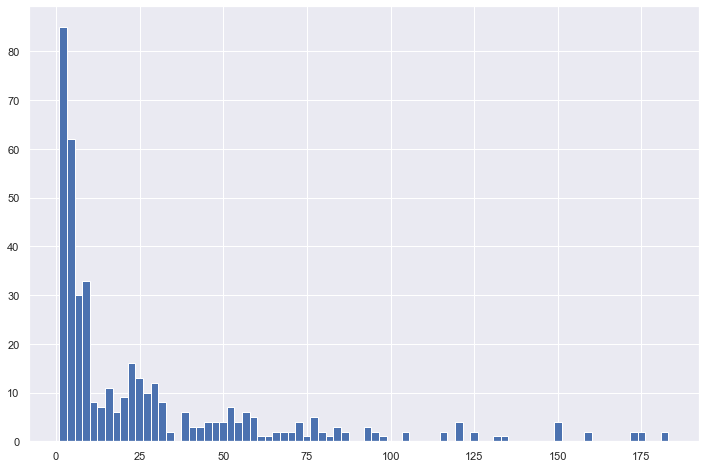

In [38]:
flt_info_solution = flt_info.groupby(['Ac Type Code','leg']).size().reset_index().sort_values(by = [0])
plt.hist(flt_info_solution[0], bins = 80)


In [39]:
leg_test = flt_info[flt_info["route"] == 'East Carmen-West Jason']
#sns.catplot(x=leg_test['leg'], y = leg_test['block_time'], data = leg_test)
#leg_test

In [40]:
flt_info['Ac Type Code'].value_counts()

320    5881
E95    3188
DH4    2357
Name: Ac Type Code, dtype: int64

 # Ground Info

In [41]:
# Ground Info Dataset
ground_info.head()

,day_of_origin,ac_type,fn_number,ac_registration,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
0,2019-06-01,DH4,EC3114,ECLGNX,35,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35,272006092,272205857,26,NaN,26.0
1,2019-06-01,320,EC3316,ECLBIX,40,East Latashaview,East Carmen,Juliemouth,2019-06-01 03:15:00,2019-06-01 07:05:00,2019-06-01 07:50:00,2019-06-01 12:05:00,45,272027070,272029306,27,NaN,15.0
2,2019-06-01,321,EC3292,ECLBAX,45,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95,272024970,272022230,27,NaN,25.0
3,2019-06-01,E95,EC3420,ECLWFX,40,East Allisontown,East Carmen,Yoderburgh,2019-06-01 04:00:00,2019-06-01 04:35:00,2019-06-01 05:30:00,2019-06-01 07:05:00,55,272034482,271961698,18,NaN,11.0
4,2019-06-01,DH4,EC3400,ECLGBX,30,Port Courtneytown,East Carmen,West Ana,2019-06-01 04:00:00,2019-06-01 04:35:00,2019-06-01 05:10:00,2019-06-01 07:10:00,35,272033720,271984663,15,NaN,12.0


In [42]:
ground_info.describe()

,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
count,4173.000000,4173.000000,4.173000e+03,4.173000e+03,4173.000000,3.000000,3769.000000
mean,39.110951,56.080757,2.720592e+08,2.720428e+08,21.959262,21.505556,18.461926
std,3.267831,17.056430,9.876997e+04,9.305571e+04,4.325588,10.667400,11.926491
min,30.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000
25%,40.000000,45.000000,2.719893e+08,2.719841e+08,18.000000,15.400000,13.000000
50%,40.000000,55.000000,2.720152e+08,2.720086e+08,22.000000,16.800000,17.000000
75%,40.000000,65.000000,2.721835e+08,2.720336e+08,26.000000,25.258333,22.000000
max,45.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000


In [43]:
ground_info.dtypes

day_of_origin            datetime64[ns]
ac_type                          object
fn_number                        object
ac_registration                  object
mingt                             int64
dep_leg_inbound                  object
arr_leg_inbound                  object
arr_leg_outbound                 object
sched_inbound_dep        datetime64[ns]
sched_inbound_arr        datetime64[ns]
sched_outbound_dep       datetime64[ns]
sched_outbound_arr       datetime64[ns]
sched_turnaround                  int64
leg_inbound                       int64
leg_outbound                      int64
catering_duration                 int64
cleaning_duration               float64
pax_boarding_duration           float64
dtype: object

## Merged Dataset

In [44]:
#Interim: We drop NAs

#flt_info = flt_info.dropna()

In [45]:
# We do a merge of both datasets before engineering flt_info

#pd.set_option("display.max_columns", 101)
#df = pd.merge(flt_info_raw, ground_info, left_on = ['fn_number', 'dep_sched_date'], right_on = ['fn_number','day_of_origin'], how = 'left')
#df.head()



NameError: name 'flt_info_raw' is not defined

<AxesSubplot:>

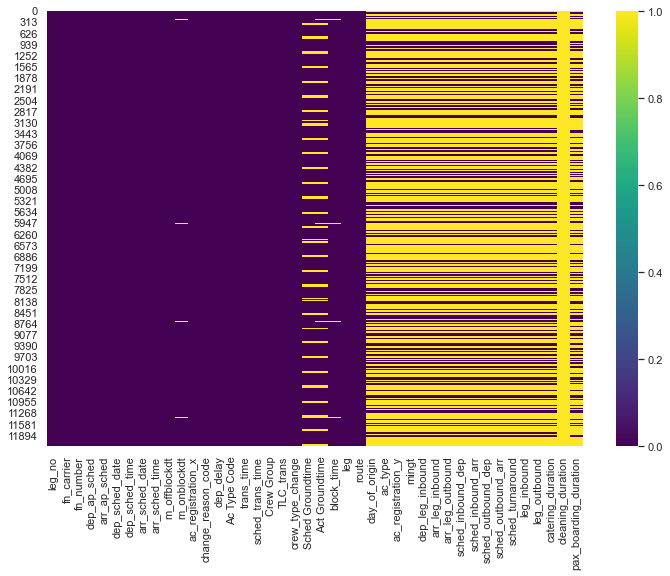

In [ ]:
#sns.heatmap(df.isna(), cmap = 'viridis' )

In [ ]:
df_interim = df
df_interim.to_csv(path_or_buf = 'C:/Users/PC Paul/Documents/Dokumente/DATA SCIENCE/Courses/Model_Engineering/Delay-Prediction/data/interim/df_interim.csv')

